# Download Data

In [ ]:
#Download data
#Over 1 GB

d = False #Already downloaded?

if not d:
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz
    !tar -xf annotations.tar.gz

In [2]:
import os

#~5k Dog + ~2.4k Cat Breeds
input_dir = "images/"
target_dir = "annotations/trimaps/"

#pet images
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

#segmentation maps
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

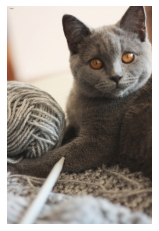

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
i = 888 #9
plt.imshow(load_img(input_img_paths[i]))

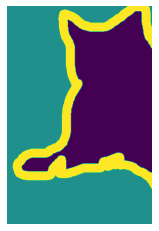

In [4]:
def display_target(target_array):
    #labels are 1,2,3. Subtract 1 to make range from 0,1,2
    #multiply by 127 so that the labels become 0 (black), 127 (gray), 254 (near-white)
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[i], color_mode="grayscale"))
display_target(img)
#3 classes for each pixel!

## Split data for segmentation

In [5]:
#train, test split
#no data iterators; loading to memory.
#ex at the bottom using datafs

import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## Split data for classification

In [6]:
#Not used in the lecture the lecture
#HW
#Create second target matrix for Cat/Dog
#SPECIES:	0:Cat	1:Dog
y_species = np.zeros(len(input_img_paths), dtype=int)

i = 0
for im in input_img_paths:
    title = im[7:].split('.', 1)[0]
    # print(title) #British_Shorthair_47
    ##images	with	small	first	letter	are	dog	images
    if title[0].islower():
        y_species[i] = 1 #Dog found
    i+=1

print("i, # of dogs found, y_shape")
print(i, y_species.sum(), y_species.shape)

i, # of dogs found, y_shape
7390 4990 (7390,)


In [7]:
#Use the same split for classification as segmentation
train_SPECIES = y_species[:-num_val_samples]
val_SPECIES = y_species[-num_val_samples:]

## Setting up the model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
def get_model(img_size, num_classes_segmentation,num_classes_species):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))
    #Scale
    x = layers.Rescaling(1./255)(inputs)

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 64 -> 256
    x = layers.Conv2D(filters=64,kernel_size=3,strides=2,activation="relu",padding="same")(x)
    x = layers.Conv2D(filters=64,kernel_size=3,activation="relu",padding="same")(x)
    # (100,100,64)
    x = layers.Conv2D(filters=128,kernel_size=3,strides=2,activation="relu",padding="same")(x)
    x = layers.Conv2D(filters=128,kernel_size=3,activation="relu",padding="same")(x)
    # (50,50,128)
    x = layers.Conv2D(filters=256,kernel_size=3,strides=2,activation="relu",padding="same")(x)
    x = layers.Conv2D(filters=256,kernel_size=3,activation="relu",padding="same")(x)
    # (25,25,256)

    # Species prediction output
    #transition from CNN to DNN: Makes it 1-D (matrix to vector)
    x2 = layers.Flatten()(x)
    species_output = layers.Dense(1, activation="sigmoid")(x2)


    #Part 2: Decode 256 -> 64
    x = layers.Conv2DTranspose(filters=256,kernel_size=3,activation="relu",padding="same")(x)
    x = layers.Conv2DTranspose(filters=256,kernel_size=3,strides=2,activation="relu",padding="same")(x)
    # (50,50,256)
    x = layers.Conv2DTranspose(filters=128,kernel_size=3,activation="relu",padding="same")(x)
    x = layers.Conv2DTranspose(filters=128,kernel_size=3,strides=2,activation="relu",padding="same")(x)
    # (100,100,128)
    x = layers.Conv2DTranspose(filters=64,kernel_size=3,activation="relu",padding="same")(x)
    x = layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,activation="relu",padding="same")(x)
    # (200,200,64)

    #Segmentation Output
    
    
    segmentation_output = layers.Conv2D(filters=num_classes_segmentation, kernel_size=3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs=[segmentation_output, species_output])
    return model

#Set up
model = get_model(img_size=img_size, num_classes_segmentation=3,num_classes_species=2)
model.summary()

2023-07-26 02:27:16.142155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 02:27:16.142379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 02:27:16.159325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 02:27:16.159561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 02:27:16.159729: I tensorflow/compiler/xla/stream_executo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [19]:
def species_accuracy(y_true, y_pred):
    return keras.metrics.binary_crossentropy(y_true, y_pred)

In [22]:
# train_targets = segmentation_labels
model.compile(optimizer='rmsprop',
              loss=['sparse_categorical_crossentropy','binary_crossentropy'],
              metrics=['accuracy'])
history = model.fit(x=train_input_imgs, y=[train_targets, train_SPECIES], epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, [val_targets,val_SPECIES]))

Epoch 1/30
200/200 [==============================] - 15s 67ms/step - loss: 0.4885 - conv2d_6_loss: 0.4469 - dense_loss: 0.0415 - conv2d_6_accuracy: 0.8232 - dense_accuracy: 0.9930 - val_loss: 4.4191 - val_conv2d_6_loss: 0.4540 - val_dense_loss: 3.9651 - val_conv2d_6_accuracy: 0.8233 - val_dense_accuracy: 0.7250
Epoch 2/30
200/200 [==============================] - 13s 66ms/step - loss: 0.4628 - conv2d_6_loss: 0.4417 - dense_loss: 0.0211 - conv2d_6_accuracy: 0.8252 - dense_accuracy: 0.9959 - val_loss: 5.1480 - val_conv2d_6_loss: 0.4487 - val_dense_loss: 4.6993 - val_conv2d_6_accuracy: 0.8236 - val_dense_accuracy: 0.7530
Epoch 3/30
200/200 [==============================] - 13s 66ms/step - loss: 0.4460 - conv2d_6_loss: 0.4299 - dense_loss: 0.0161 - conv2d_6_accuracy: 0.8302 - dense_accuracy: 0.9972 - val_loss: 5.8883 - val_conv2d_6_loss: 0.4430 - val_dense_loss: 5.4452 - val_conv2d_6_accuracy: 0.8259 - val_dense_accuracy: 0.7420
Epoch 4/30
200/200 [==============================] - 13s 

In [25]:
model.save('segmentation.h5')

<Figure size 864x648 with 0 Axes>

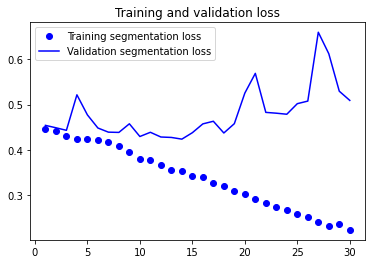

In [56]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
conv2d_6_loss = history.history["conv2d_6_loss"]
val_conv2d_6_loss = history.history["val_conv2d_6_loss"]
dense_loss = history.history["dense_loss"]
val_dense_los= history.history["val_dense_loss"]
plt.figure()
plt.plot(epochs, conv2d_6_loss, "bo", label="Training segmentation loss")
plt.plot(epochs, val_conv2d_6_loss, "b", label="Validation segmentation loss")

plt.title("Training and validation loss")
plt.legend()
#When do we overfit?

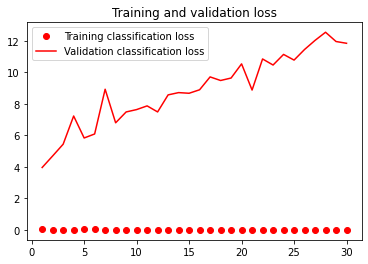

In [57]:
plt.figure()
plt.plot(epochs, dense_loss, "ro", label="Training classification loss")
plt.plot(epochs, val_dense_los, "r", label="Validation classification loss")

plt.title("Training and validation loss")
plt.legend()

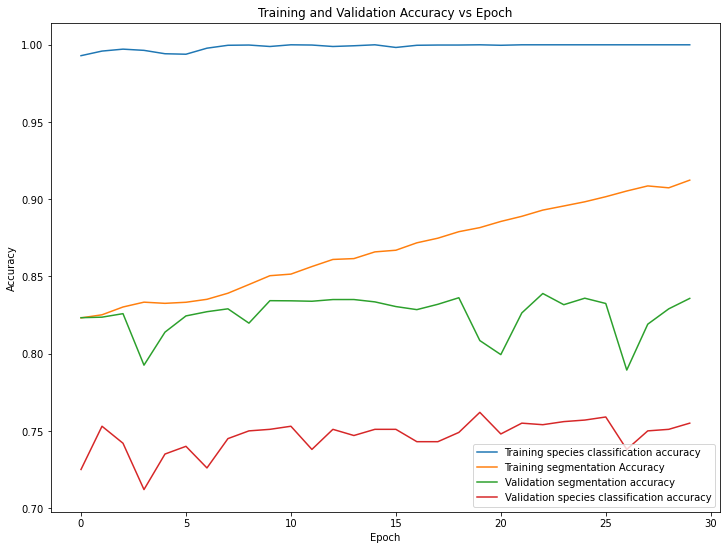

In [47]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['dense_accuracy'], label='Training species classification accuracy')
plt.plot(history.history['conv2d_6_accuracy'], label='Training segmentation Accuracy')
plt.plot(history.history['val_conv2d_6_accuracy'], label='Validation segmentation accuracy')
plt.plot(history.history['val_dense_accuracy'], label='Validation species classification accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy vs Epoch')
plt.show()

## Testing Result

1/1 [==============================] - 0s 109ms/step


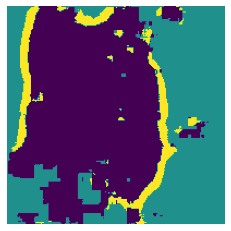

In [90]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model('./segmentation.h5')

i = 33 #4
test_image = val_input_imgs[i]

mask = model.predict(np.expand_dims(test_image, 0))[0][0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)


In [91]:
# 0:Cat	1:Dog
species_predictation = model.predict(np.expand_dims(test_image, 0))[1]
if species_predictation <=0.5:
    print("this is a cat")
else:
    print("this is a dog")

1/1 [==============================] - 0s 24ms/step
this is a dog


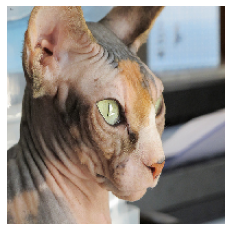

In [92]:
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [96]:
cl_result=[]
num_dog=0
num_cat=0
for i in range(0,100):
    test_image = val_input_imgs[i]
    predict_result = model.predict(np.expand_dims(test_image, 0))[1][0][0]
    if predict_result <=0.5:
        cl_result.append(0)
        num_cat+=1
    else:
        cl_result.append(1)
        num_dog+=1
print("number of cat:",num_cat)
print("number of dog:",num_dog)
    

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
number of cat: 28
number of dog: 72
